# Sentiment Analysis with BERT and Transformers by Hugging Face using PyTorch
Scrape Google Play data. Implement Transfer Learning to build Sentiment Classifier using the Transformers library.

In [ ]:
%reload_ext watermark
%watermark -v -p numpy
print('--------------------')
%watermark -v -p pandas
print('--------------------')
%watermark -v -p torch
print('--------------------')
%watermark -v -p transformers

CPython 3.6.6
IPython 7.10.1

numpy 1.17.4
--------------------
CPython 3.6.6
IPython 7.10.1

pandas 0.25.3
--------------------
CPython 3.6.6
IPython 7.10.1

torch 1.5.0
--------------------
CPython 3.6.6
IPython 7.10.1

transformers 2.8.0


In [1]:
!pip install transformers
!pip install google_play_scraper

     |████████████████████████████████| 675kB 15.3MB/s 
     |████████████████████████████████| 890kB 18.7MB/s 
     |████████████████████████████████| 1.1MB 53.4MB/s 
     |████████████████████████████████| 3.8MB 46.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=7dac0c4b30f7fd25150400216bb99e01fb754d7c385e876c4c7062b636eaf552
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 51kB 6.4MB/s 
  Created wheel for google-play-scraper: filename=google_play_scraper-0.0.2.6-cp36-none-any.whl size=21656 sha256=f7540e89384605c966023cd326eded3c7aecbc8a9c8bdb1f64d693c5d90a499b
  Stored in directory: /root/.cache/pip/wheels/d3/e5/33/a2bf24cd05142c8258c39e6a4bc0e75e06b38897ccaf1b0157
Successfully built google-play-scraper


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
import os
import transformers
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import pandas as pd
import torch.nn.functional as F
from tqdm import tqdm
from pygments import highlight
from pygments.lexers import JsonLexer
from pygments.formatters import TerminalFormatter
from google_play_scraper import Sort, reviews, app
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from pylab import rcParams
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ['#01BEFE', '#FFDD00', '#FF7D00', '#FF006D', '#ADFF02', '#8F00FF']
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Scraping data
Choose some _Productivity_ apps, scrape the data, and structure for sentiment analysis.

In [6]:
app_packages = [
  'com.anydo',
  'com.todoist',
  'com.ticktick.task',
  'com.habitrpg.android.habitica',
  'cc.forestapp',
  'com.oristats.habitbull',
  'com.levor.liferpgtasks',
  'com.habitnow',
  'com.microsoft.todos',
  'prox.lab.calclock',
  'com.gmail.jmartindev.timetune',
  'com.artfulagenda.app',
  'com.tasks.android',
  'com.appgenix.bizcal',
  'com.appxy.planner'
]

In [7]:
app_infos = []

for ap in tqdm(app_packages):
    info = app(
        ap,
        lang='en',
        country='us'
    )
    del info['comments']
    app_infos.append(info)

100%|██████████| 15/15 [00:02<00:00,  5.73it/s]


In [8]:
def print_json(json_object):
    '''
    takes json object
    returns prettier printed json object
    '''
    json_str = json.dumps(
        json_object,
        indent=2,
        sort_keys=True,
        default=str
    )
    print(highlight(json_str, JsonLexer(), TerminalFormatter()))

In [ ]:
# Printing the first object in the json
print_json(app_infos[0])

{
  "adSupported": null,
  "androidVersion": "Varies",
  "androidVersionText": "Varies with device",
  "appId": "com.anydo",
  "containsAds": null,
  "contentRating": "Everyone",
  "contentRatingDescription": null,
  "currency": "USD",
  "description": "<b>\ud83c\udfc6 Editor's Choice by Google</b>\r\n\r\nAny.do is a To Do List, Calendar, Planner, Tasks & Reminders App That Helps Over 25M People Stay Organized and Get More Done.\r\n\r\n<b>\ud83e\udd47 \"It\u2019s A MUST HAVE PLANNER & TO DO LIST APP\" (NYTimes, USA TODAY, WSJ & Lifehacker).</b>\r\n\r\nAny.do is a free to-do list, planner & calendar app for managing and organizing your daily tasks, to-do lists, notes, reminders, checklists, calendar events, grocery lists and more.\r\n\r\n\ud83d\udcc5 Organize Your Tasks & To-Do List in Seconds\r\n\r\n\u2022 ADVANCED CALENDAR & DAILY PLANNER - Keep your to-do list and calendar events always at hand with our calendar widget. Any.do to-do list & planner support daily calendar view, 3-day C

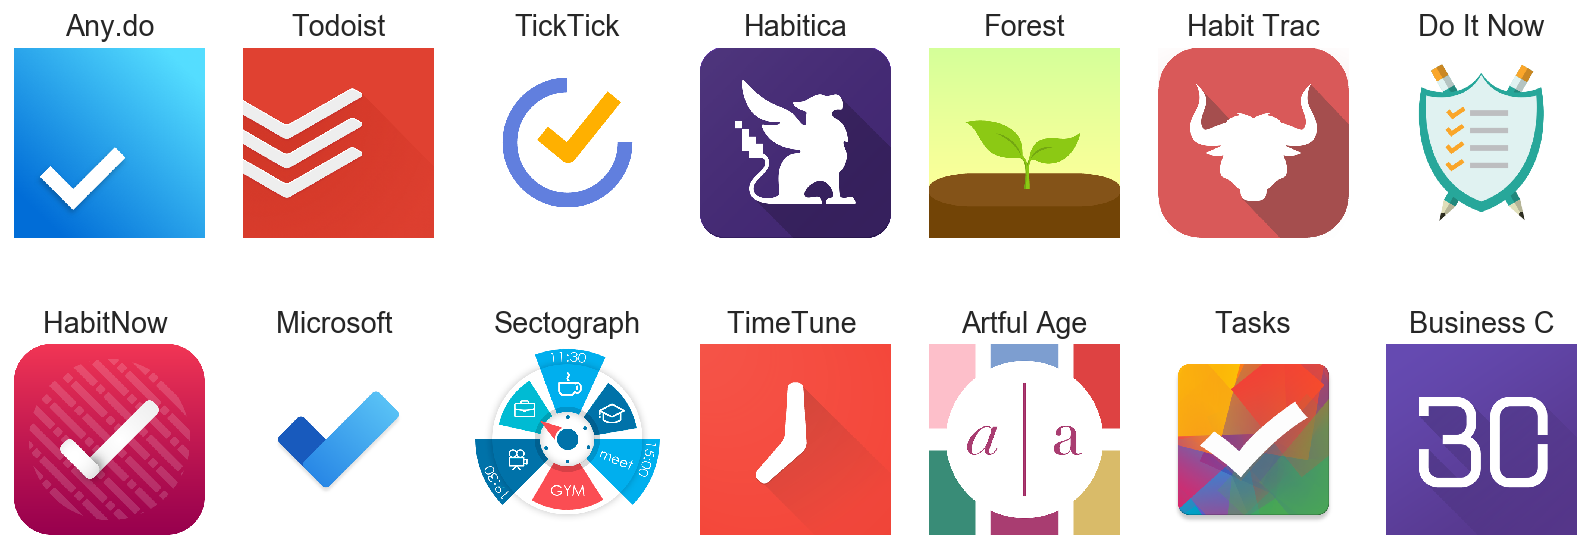

In [ ]:
def format_title(title):
    sep_index = title.find(':') if title.find(':') != -1 else title.find('-')
    if sep_index != -1:
        title = title[:sep_index]
    return title[:10]

fig, axs = plt.subplots(2, len(app_infos) // 2, figsize=(14, 5))

for i, ax in enumerate(axs.flat):
    ai = app_infos[i]
    img = plt.imread(ai['icon'])
    ax.imshow(img)
    ax.set_title(format_title(ai['title']))
    ax.axis('off')

In [ ]:
app_infos_df = pd.DataFrame(app_infos)

We want:
- Balanced dataset; roughly the same number of reviews for each score
- Representative sample of reviews for each app

We satify the first requirement by using the scraping package option to filter the review score. For the second, we'll sort the reviews by their helpfulness but also get a subset from the newest.

In [9]:
app_reviews = []

for ap in tqdm(app_packages):
    for score in list(range(1, 6)):
        for sort_order in [Sort.MOST_RELEVANT, Sort.NEWEST]:
            rvs, _ = reviews(
                ap,
                lang='en',
                country='us',
                sort=sort_order,
                count=200 if score == 3 else 100,
                filter_score_with=score
            )
            for r in rvs:
                r['sortOrder'] = 'most_relevant' if sort_order == Sort.MOST_RELEVANT else 'newest'
                r['appId'] = ap
            app_reviews.extend(rvs)

100%|██████████| 15/15 [00:48<00:00,  3.24s/it]


In [10]:
print_json(app_reviews[0])

{
  "appId": "com.anydo",
  "at": "2020-06-11 18:05:05",
  "content": "It's testing the edge of my patience. Even though I have better internet connection it keeps saying \"couldn't find the Internet connection. Try again later\". It's my first time. I can't sign in so I can't go in to the app and plan anything. Already I tried reinstall twice.",
  "repliedAt": "2020-06-14 06:54:58",
  "replyContent": "Sorry about that. Please note that there could be many reasons for a connectivity issue, though, the app can be used offline too. Please contact us at- https://www.any.do/contact_form, and we will be happy to look into it for you.",
  "reviewCreatedVersion": "5.1.2.2",
  "reviewId": "gp:AOqpTOEqqf7E54aID32Kn6OtoJJ3x4E1aP8wEy0Ox-n34uhHMtuPq5dgp7l0ftrZYPlighFJOR3Uy9TSHnv7Pw",
  "score": 1,
  "sortOrder": "most_relevant",
  "thumbsUpCount": 52,
  "userImage": "https://lh3.googleusercontent.com/a-/AOh14Gh3-1bCxGecUwAb9PSrU9eDhsxX7rH3SmzC5lZ-",
  "userName": "Miss. Phoenix"
}



In [11]:
print('Number of app reviews we acquired: {}'.format(len(app_reviews)))

Number of app reviews we acquired: 15986


In [12]:
app_reviews_df = pd.DataFrame(app_reviews)
app_reviews_df.to_csv(os.path.basename('reviews.csv'), index=None, header=True)

In [13]:
# load reviews dataset
df = pd.read_csv(os.path.basename('reviews.csv'))
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,gp:AOqpTOEqqf7E54aID32Kn6OtoJJ3x4E1aP8wEy0Ox-n...,Miss. Phoenix,https://lh3.googleusercontent.com/a-/AOh14Gh3-...,It's testing the edge of my patience. Even tho...,1,52,5.1.2.2,2020-06-11 18:05:05,Sorry about that. Please note that there could...,2020-06-14 06:54:58,most_relevant,com.anydo
1,gp:AOqpTOGt2KEhc-yNMmOBsXqfHKLGJ-vDENQPVPlGZIM...,Earl Clark,https://lh3.googleusercontent.com/a-/AOh14Gj_X...,"This is an expensive app. That being said, it'...",1,212,5.1.1.13,2020-06-05 01:47:31,"To delete a task, tap the X button on a comple...",2020-06-07 07:28:30,most_relevant,com.anydo
2,gp:AOqpTOFTFzuwGKy1iy9NWAB-V53ZJusqDp-PumOpJOX...,Jesse Osby,https://lh3.googleusercontent.com/a-/AOh14Gh5M...,App is getting worse instead of better. Latest...,1,6,4.19.0.6,2020-06-01 15:58:18,There are several Any.do widget options to cho...,2020-06-02 07:05:14,most_relevant,com.anydo
3,gp:AOqpTOH2ou4mQwArywxyiAgCcsANFrqYrYLUUPjNSsJ...,Akash Porwal,https://lh3.googleusercontent.com/a-/AOh14GjmG...,Interface is so rigid. To perform some basic t...,1,108,4.19.0.6,2020-04-28 17:53:32,NaN,NaN,most_relevant,com.anydo
4,gp:AOqpTOFrErdLATiayT1WsYNOvnMaDhlI-itJWIjTEp4...,Khrystal Angelica Verboom,https://lh3.googleusercontent.com/a-/AOh14GgNF...,the app keeps crashing whenever I click someth...,1,1,5.1.1.13,2020-06-10 19:42:00,Sorry about that. Please uninstall and reinsta...,2020-06-11 06:54:21,most_relevant,com.anydo


We'll study the shape of the dataset, look for missing values in score and review content, and see if class imbalance exists.

In [14]:
df.shape

(15986, 12)

In [15]:
# look for missing values in score and review content
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15986 entries, 0 to 15985
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              15986 non-null  object
 1   userName              15986 non-null  object
 2   userImage             15986 non-null  object
 3   content               15986 non-null  object
 4   score                 15986 non-null  int64 
 5   thumbsUpCount         15986 non-null  int64 
 6   reviewCreatedVersion  13719 non-null  object
 7   at                    15986 non-null  object
 8   replyContent          7908 non-null   object
 9   repliedAt             7908 non-null   object
 10  sortOrder             15986 non-null  object
 11  appId                 15986 non-null  object
dtypes: int64(2), object(10)
memory usage: 1.5+ MB


Text(0.5, 0, 'review score')

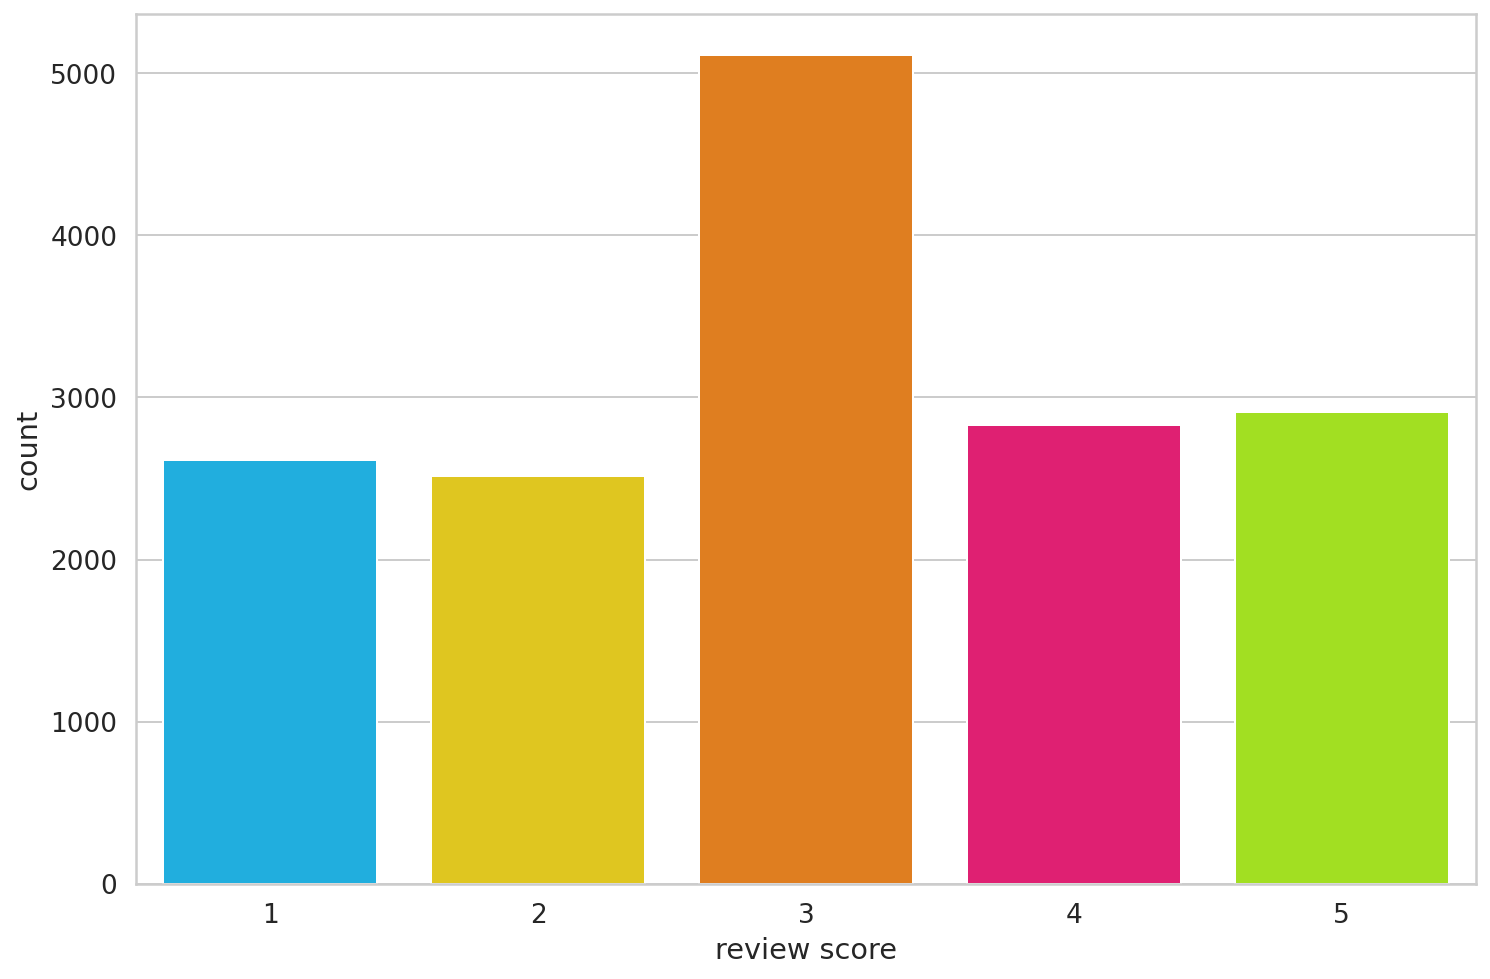

In [16]:
# look for class imbalance
sns.countplot(df.score)
plt.xlabel('review score')

[Text(0, 0, 'negative'), Text(0, 0, 'neutral'), Text(0, 0, 'positive')]

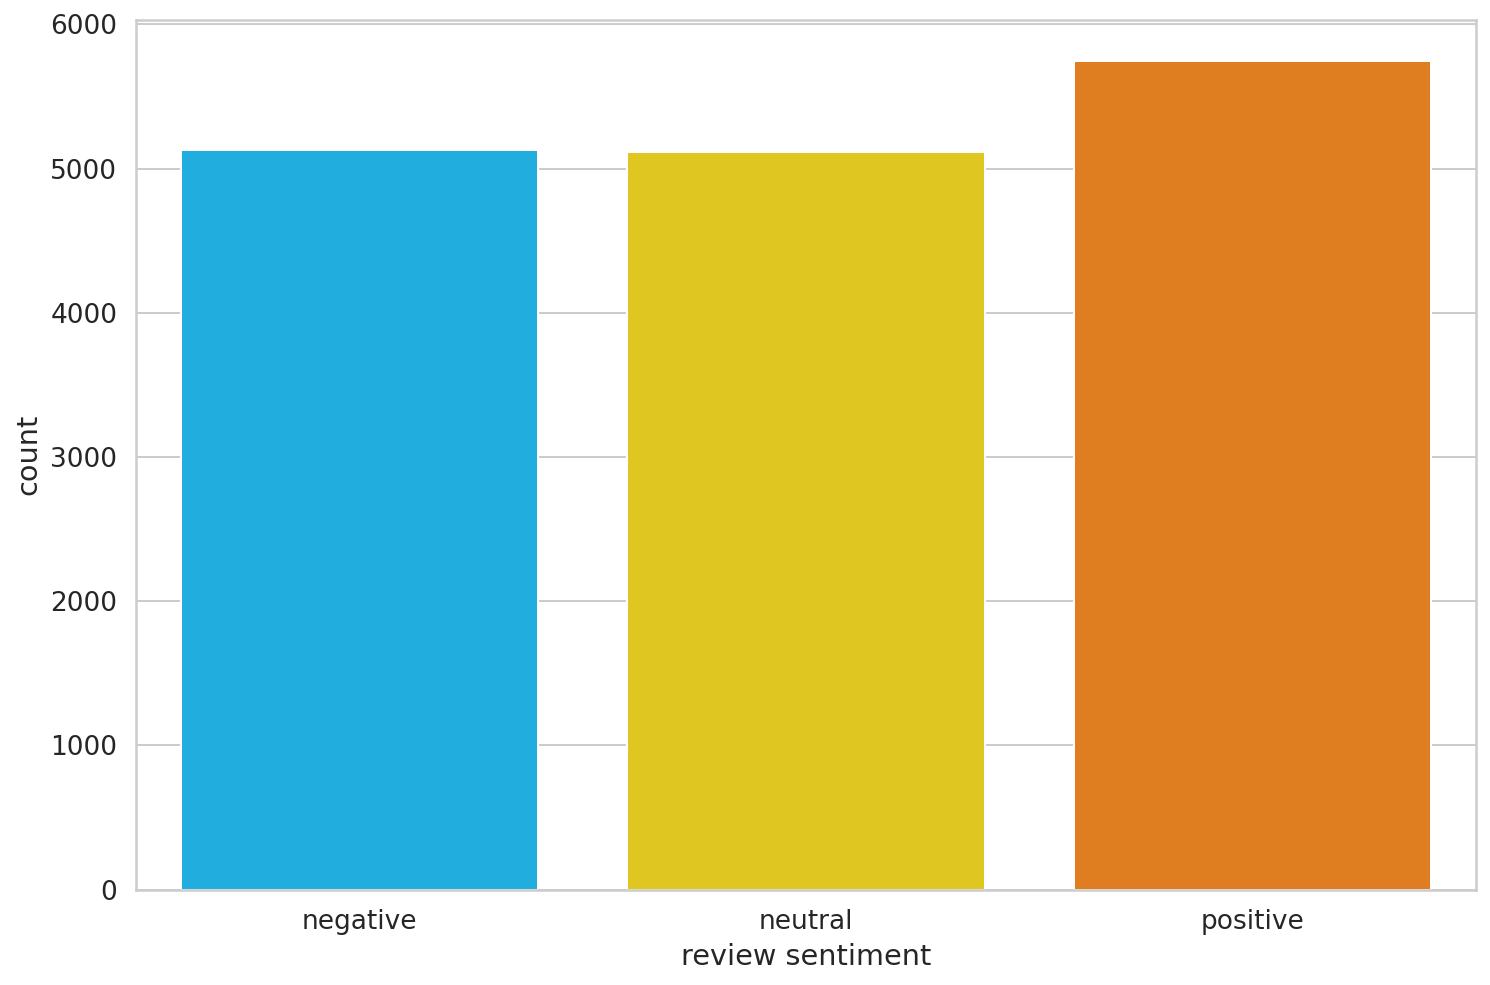

In [17]:
# convert into negative, neutral, and positive sentiment
def to_sentiment(rating):
    '''
    takes series of scores
    returns series with values less than 3 as negative, 3 as neutral, and greater than 3 as positive
    '''
    rating = int(rating)
    if rating <= 2:
        return 0
    elif rating == 3:
        return 1
    else:
        return 2
    
df['sentiment'] = df.score.apply(to_sentiment)
class_names = ['negative', 'neutral', 'positive']

ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names)

## Data Preprocessing
Requirements for BERT to work:
- Add special tokens to separate sentences and do classification
- Pass sequences of constant length (introduce padding)
- Create array of 0s (pad token) and 1s (real token) called _attention mask_.

The transformers library provides a wide variety of transformer models (including BERT). It also includes prebuilt tokenizers that do the heavy lifting. We will be using the cased version of BERT and tokenizer.

In [18]:
# load a pre-trained BertTokenizer
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

### Understanding and visualizing the tokenization process.

In [19]:
sample_txt = 'When was I last outside? I have been stuck at home for 1 month.'
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

In [20]:
print(f'Sentence: {sample_txt}')
print(f'Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

Sentence: When was I last outside? I have been stuck at home for 1 month.
Tokens: ['When', 'was', 'I', 'last', 'outside', '?', 'I', 'have', 'been', 'stuck', 'at', 'home', 'for', '1', 'month', '.']
Token IDs: [1332, 1108, 146, 1314, 1796, 136, 146, 1138, 1151, 5342, 1120, 1313, 1111, 122, 2370, 119]


Special tokens:
- [SEP] marker for ending sentences
- [CLS] must add this token to the start of each sentence so BERT knows that we're doing classification
- [UNK] encode everything not in the training set with this as BERT already understands tokens in the training set

In [21]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

In [22]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

In [23]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [24]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

In [25]:
# encode_plus() method handles all of the above special token work
encoding = tokenizer.encode_plus(
    sample_txt,
    max_length=32,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt'
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [26]:
# token ids
print(len(encoding['input_ids'][0]))
encoding['input_ids']

32


tensor([[ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1138, 1151, 5342, 1120,
         1313, 1111,  122, 2370,  119,  102,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]])

In [27]:
# attention mask
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [28]:
# testing inversing the tokenization
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'When',
 'was',
 'I',
 'last',
 'outside',
 '?',
 'I',
 'have',
 'been',
 'stuck',
 'at',
 'home',
 'for',
 '1',
 'month',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

## Choosing sequence length
We'll use a simple strategy to choose the max length.

In [29]:
token_lens = []

for txt in df.content:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

Text(0.5, 0, 'Token count')

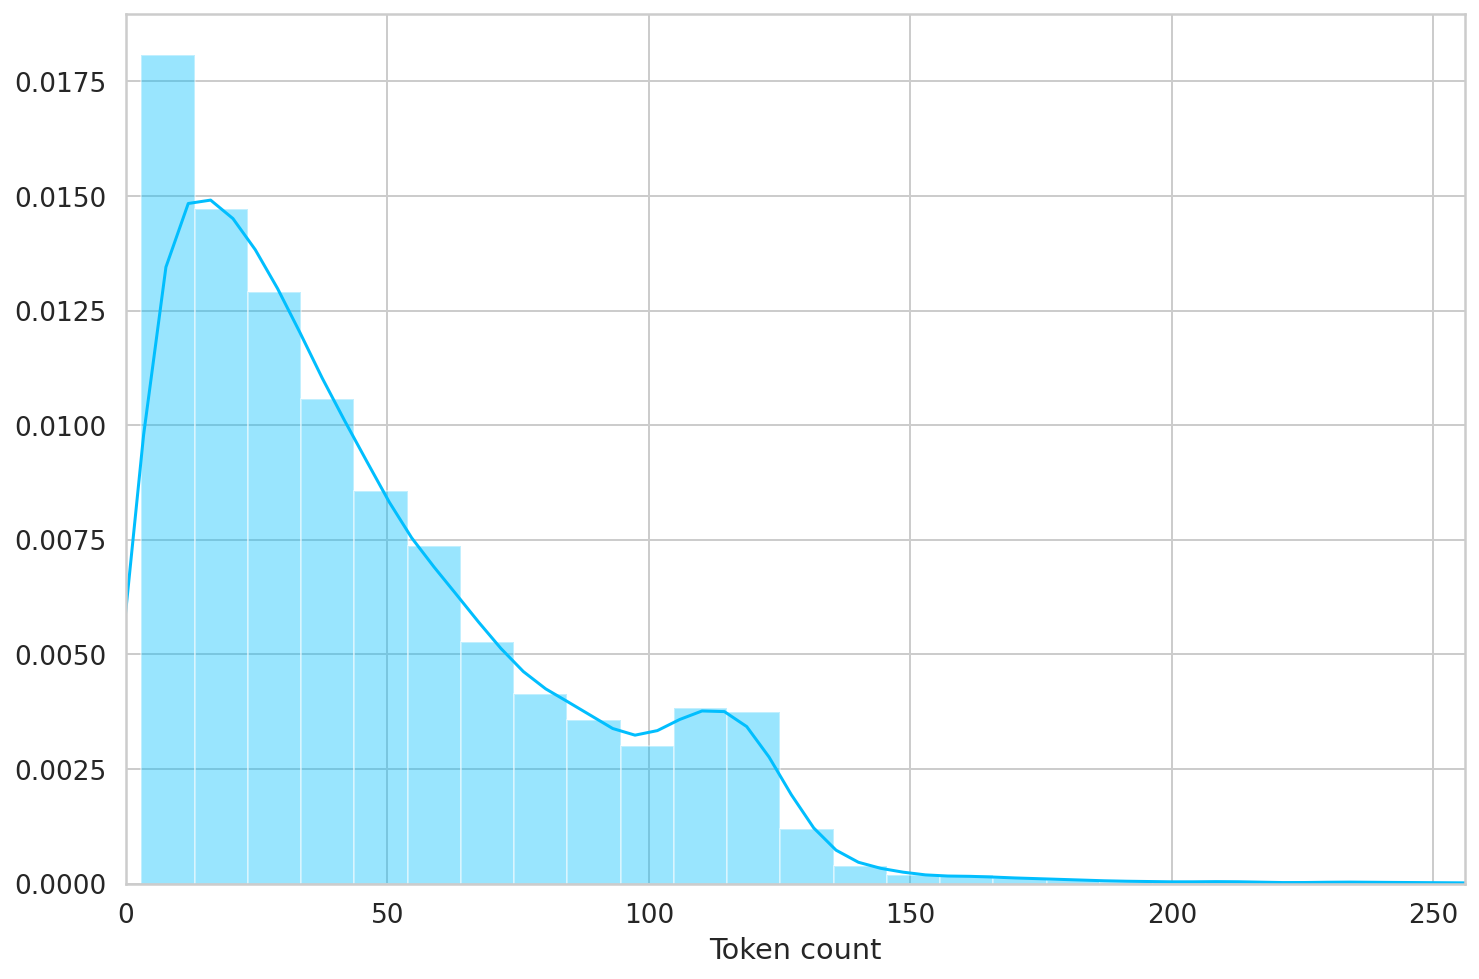

In [30]:
sns.distplot(token_lens)
plt.xlim([0, 256])
plt.xlabel('Token count')

Most reviews seem to be less than 150 tokens, we'll be on the safe side and choose a maximum length of 160.

In [31]:
MAX_LEN = 160

With the building blocks laid out, we'll create a PyTorch dataset/data model.

In [32]:
class GPReviewDataset(Dataset):
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
        
        
    def __len__(self):
        return len(self.reviews)
    
    
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

We choose to return review texts to easily evaluate predictions from our model. Let's split the data.

In [33]:
df_train, df_test = train_test_split(
    df,
    test_size=0.1,
    random_state=RANDOM_SEED
)

df_val, df_test = train_test_split(
    df_test,
    test_size=0.5,
    random_state=RANDOM_SEED
)

df_train.shape, df_val.shape, df_test.shape

((14387, 13), (799, 13), (800, 13))

Helper function to create data loaders.

In [34]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df.content.to_numpy(),
        targets=df.sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=9
    )

In [35]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

An example batch from the training data loader.

In [36]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [37]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


## Sentiment classification with BERT and Hugging Face
Depending on the task, we can use BertForSequenceClassification, BertForQuestionAnswering, but here we will use the basic BertModel and build a sentiment classifier on top of it.

In [38]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Use on encoding of our sample text.

In [39]:
last_hidden_state, pooled_output = bert_model(
    input_ids=encoding['input_ids'],
    attention_mask=encoding['attention_mask']
)

The `last_hidden_state` is a sequence of hidden states of the last layer of the model. Obtaining the `pooled_output` is done by applying BertPooler on `last_hidden_state`. The `pooled_output` can be considered a summary of the content according to BERT. We could try to do better, if needed.

In [40]:
last_hidden_state.shape

torch.Size([1, 32, 768])

In [41]:
pooled_output.shape

torch.Size([1, 768])

**Note:** We'll find a hidden state for each of our 32 tokens (length of example sequence). 768 is the number of hidden units in the feedforward networks which we can verify by checking the config.

In [42]:
bert_model.config.hidden_size

768

Creating a classifier using the BERT model.

In [43]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
        
    
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        output = self.drop(pooled_output)
        return self.out(output)

We use a dropout layer for some regularization and a fully connected layer for our output. We return the raw output of the last layer for crossentropy loss funtion in PyTorch to work.

In [44]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

Move example batch of training data to the device.

In [45]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

# batch size x sequence length expected
print(input_ids.shape)
print(attention_mask.shape)

torch.Size([16, 160])
torch.Size([16, 160])


To get predicted probabilities from our trained model, we'll apply the softmax function to the outputs.

In [46]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.4142, 0.1687, 0.4171],
        [0.5193, 0.1386, 0.3421],
        [0.2827, 0.1435, 0.5738],
        [0.5576, 0.1222, 0.3202],
        [0.5926, 0.1716, 0.2358],
        [0.3427, 0.1840, 0.4733],
        [0.4032, 0.1338, 0.4630],
        [0.3261, 0.2719, 0.4021],
        [0.3233, 0.1414, 0.5353],
        [0.2600, 0.2205, 0.5195],
        [0.4039, 0.1521, 0.4440],
        [0.4123, 0.2143, 0.3734],
        [0.5398, 0.0869, 0.3733],
        [0.5015, 0.1514, 0.3470],
        [0.3896, 0.1729, 0.4374],
        [0.3545, 0.1867, 0.4588]], device='cuda:0', grad_fn=<SoftmaxBackward>)

## Training
We'll use the AdamW optimizer provided by Hugging Face. It corrects weight decay. We'll also use a linear scheduler with no warmup steps.

In [47]:
EPOCHS = 3

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

The BERT authors have suggestions for fine tuning parameters:
- Batch size: 16, 32
- Learning rate (Adam): 5e-5, 3e-5, 2e-5
- Number of epochs: 2, 3, 4

**Note**: Increasing batch size reduces training time significantly, but gives lower accuracy.

We'll write helper functions for training our model for one epoch, and to evaluate our model on a given data loader.

In [48]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    
    losses = []
    correct_predictions = 0
    
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        
    return correct_predictions.double() / n_examples, np.mean(losses)
    
    
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            _, preds = torch.max(outputs, dim=1)
            
            loss = loss_fn(outputs, targets)
            
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
    
    return correct_predictions.double() / n_examples, np.mean(losses)

We can now write the training loop using the two, and we'll save the training history.

In [49]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )
    
    print(f'Train loss {train_loss} accuracy {train_acc}')
    
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )
    
    print(f'Val   loss {val_loss} accuracy {val_acc}')
    
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/3
----------
Train loss 0.7257194877001975 accuracy 0.677000069507194
Val   loss 0.5869742596149444 accuracy 0.7634543178973717
Epoch 2/3
----------
Train loss 0.41623509743147424 accuracy 0.8427747271842636
Val   loss 0.4781946063041687 accuracy 0.8322903629536922
Epoch 3/3
----------
Train loss 0.24405351255709926 accuracy 0.9205532772641969
Val   loss 0.5532028724253177 accuracy 0.851063829787234
CPU times: user 12min 45s, sys: 8min 30s, total: 21min 15s
Wall time: 21min 25s


We store state of best model based on highest validation accuracy

Plot training vs. validation accuracy.

(0.0, 1.0)

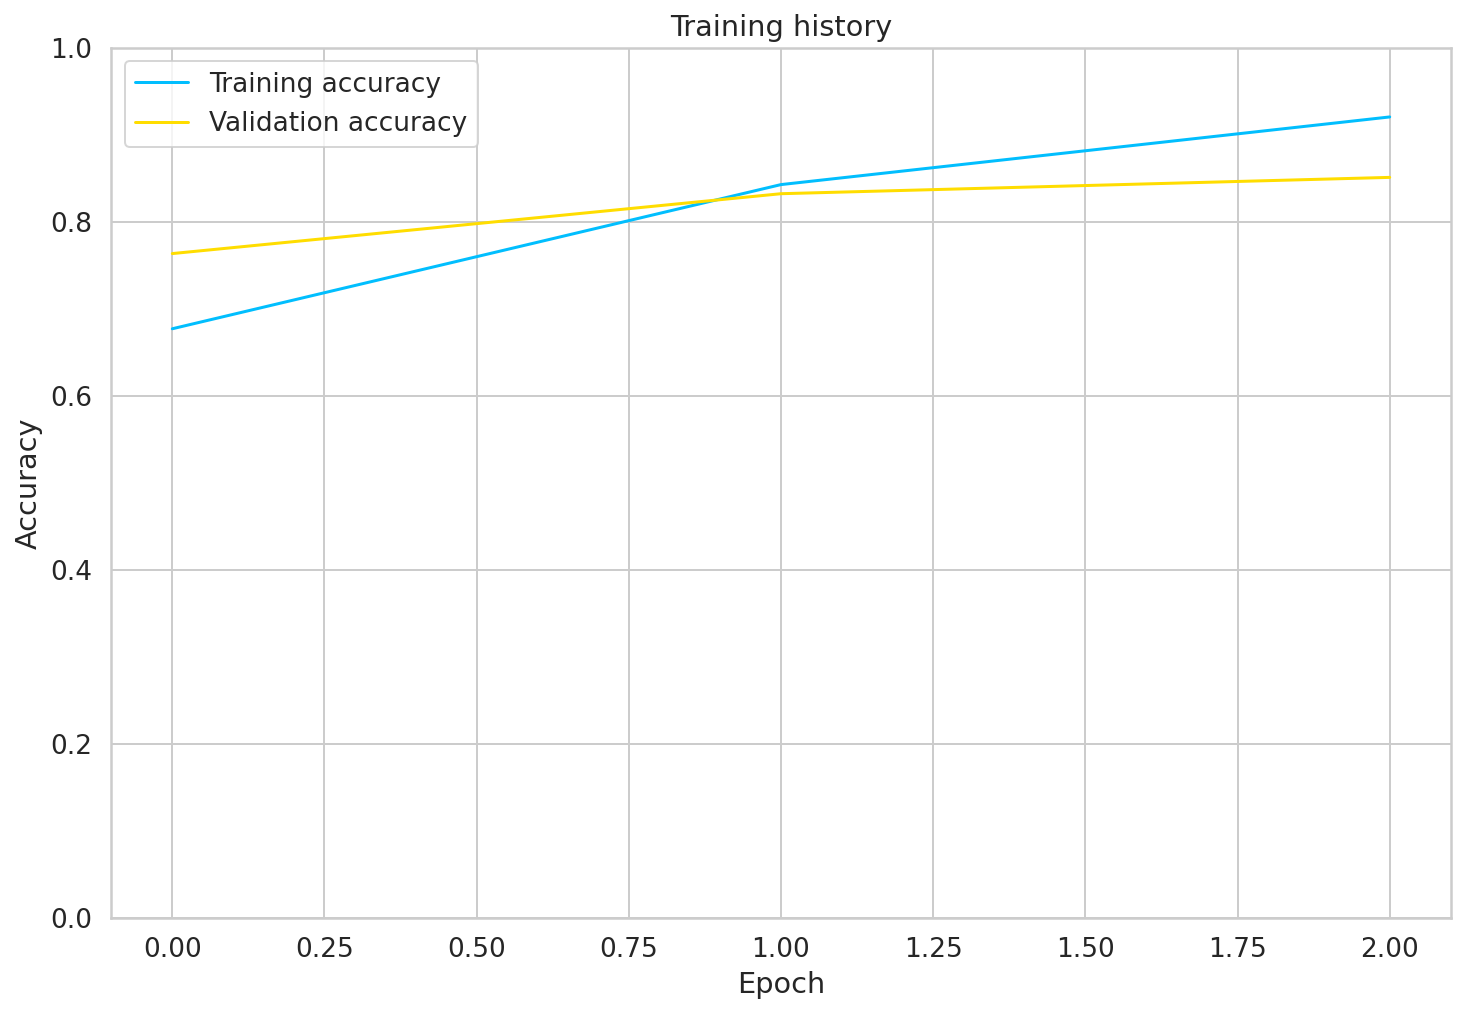

In [50]:
plt.plot(history['train_acc'], label='Training accuracy')
plt.plot(history['val_acc'], label='Validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])

## Evaluation
First, calculate the accuracy on test data.

In [51]:
test_acc, _ = eval_model(
    model,
    test_data_loader,
    loss_fn,
    device,
    len(df_test)
)

test_acc.item()

0.83875

The model seems to generalize well. We'll define a helper function to get predictions from our model.

In [52]:
def get_predictions(model, data_loader):
    model = model.eval()
    
    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []
    
    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            _, preds = torch.max(outputs, dim=1)
            
            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)
            
    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return review_texts, predictions, prediction_probs, real_values

In [53]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    test_data_loader
)

Let's view both the classification report and the confusion matrix.

In [54]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.85      0.84      0.84       246
     neutral       0.75      0.84      0.79       238
    positive       0.91      0.84      0.88       316

    accuracy                           0.84       800
   macro avg       0.84      0.84      0.84       800
weighted avg       0.84      0.84      0.84       800



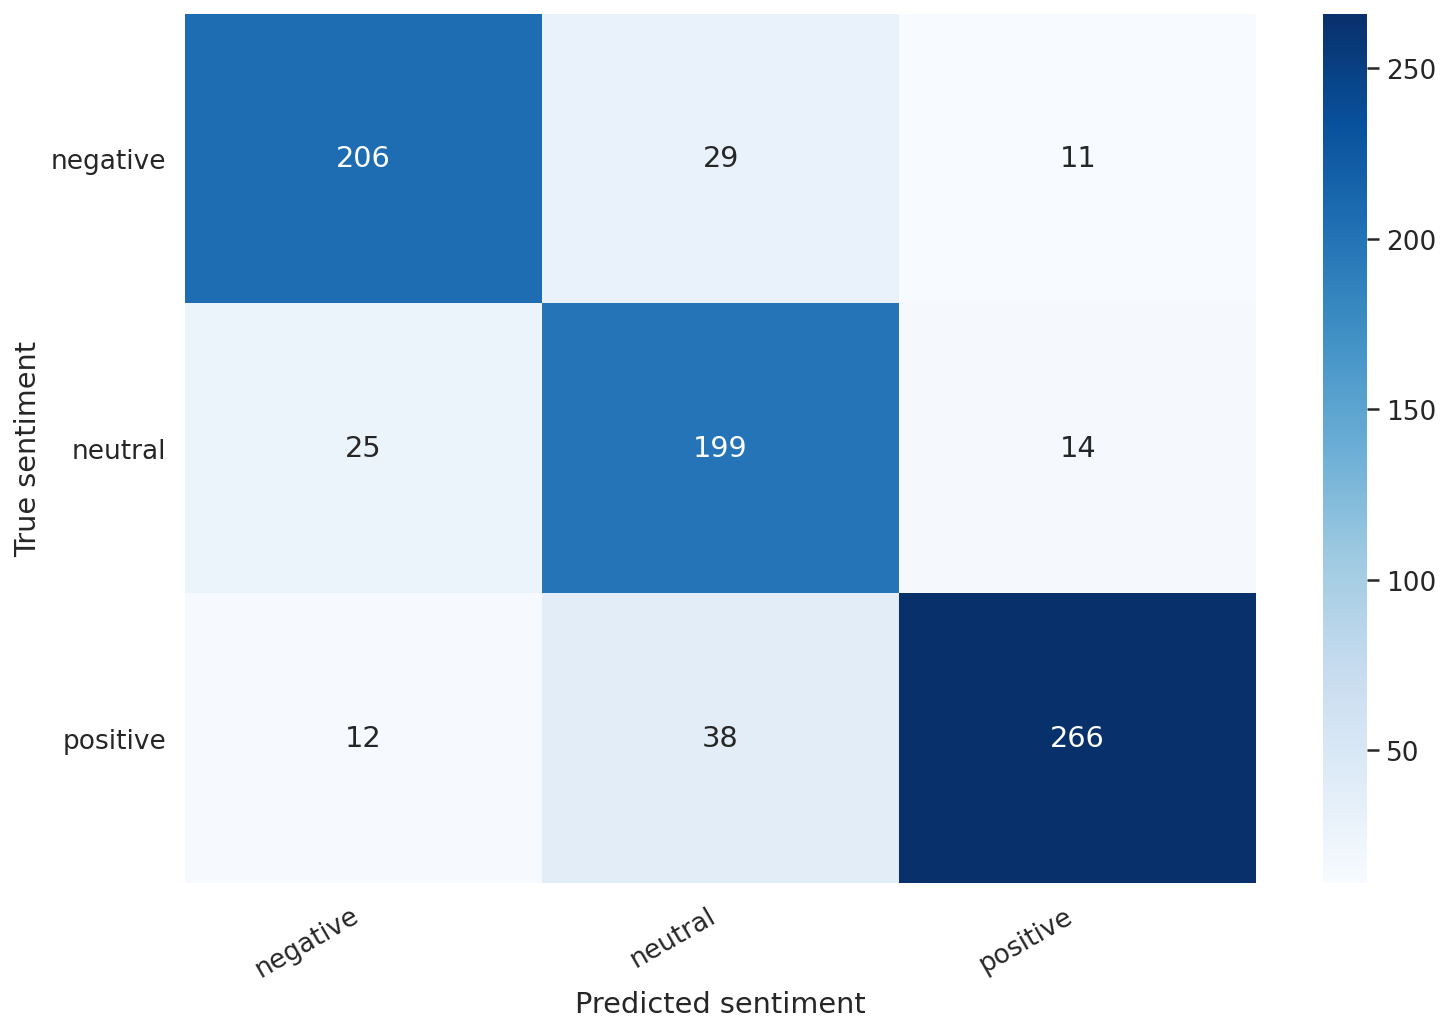

In [55]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment')
    
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

The model has difficulty in classifying neutral reviews. This is a good overview of performance, now let's look at an example from our test data.

In [56]:
idx = 2

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_sentiment = y_pred[idx]
pred_df = pd.DataFrame({
    'class_names': class_names,
    'values': y_pred_probs[idx]
})

print("\n".join(wrap(review_text)))
print('-'*20)
print(f'True sentiment: {class_names[true_sentiment]}')
print('-'*20)
print(f'Predicted sentiment: {class_names[pred_sentiment]}')

Pretty decent check list app. I like how you can set up reoccurring
tasks. I recommend it for anyone moving away from paper planners.
--------------------
True sentiment: positive
--------------------
Predicted sentiment: positive


Confidence of each sentiment of our model.

(0.0, 1.0)

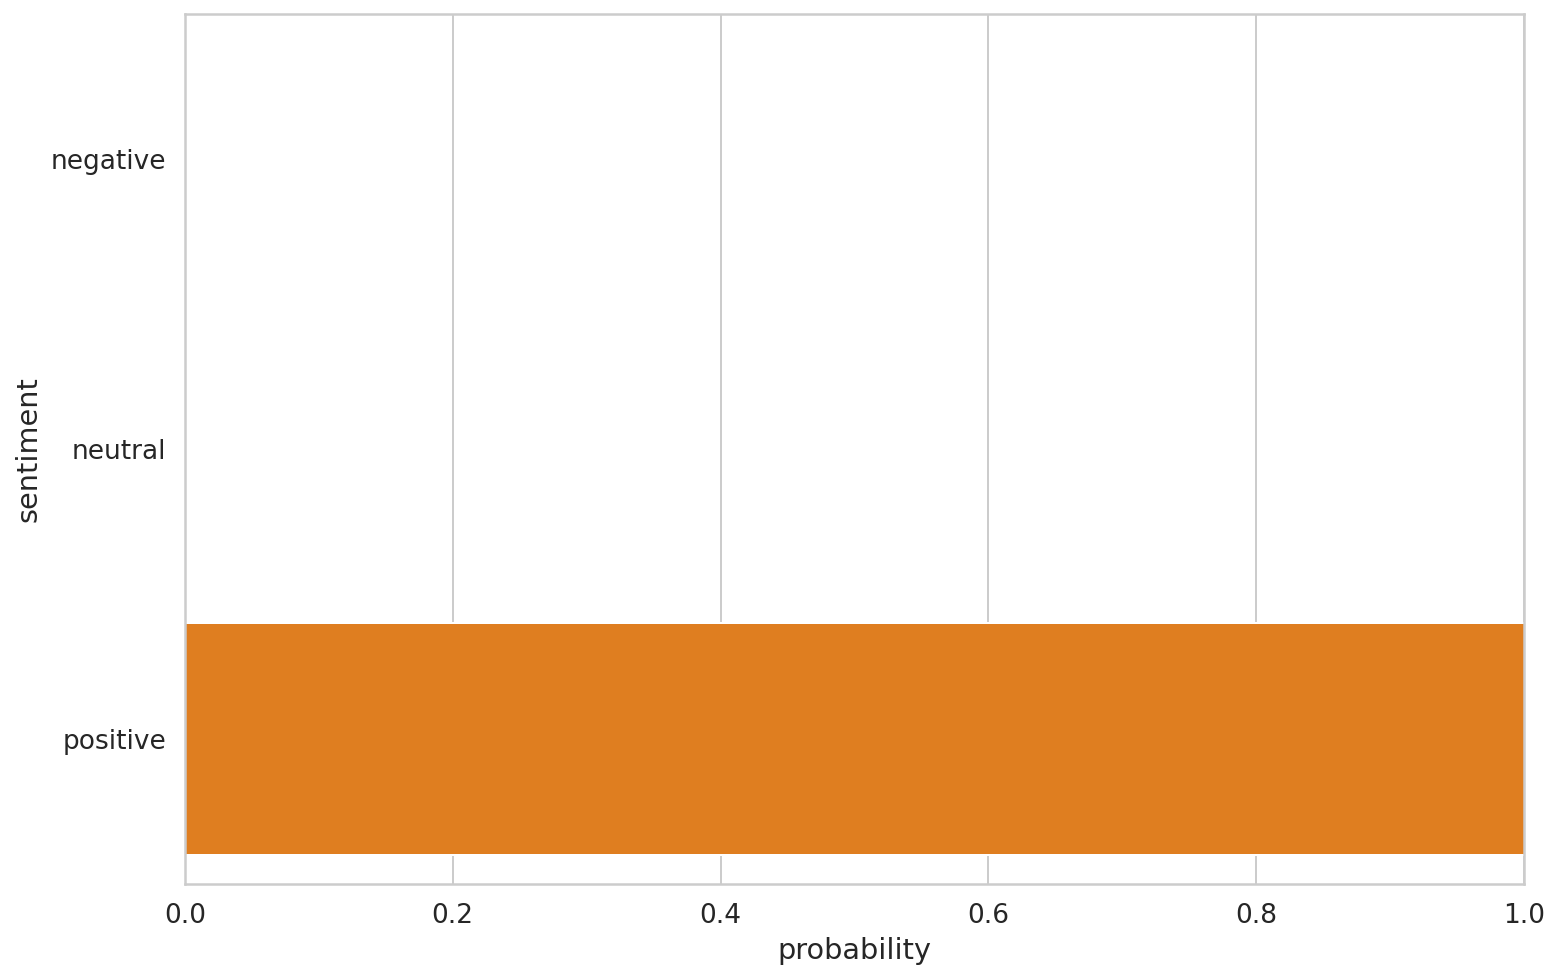

In [57]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1])

## Predicting on raw text
Let's use this model to predict the sentiment of some raw text.

In [58]:
review_text = "I love completing my todos! Best app ever!!!"

In [59]:
encoded_review = tokenizer.encode_plus(
    review_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt'
)

Predictions from our model.

In [60]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: I love completing my todos! Best app ever!!!
Sentiment  : positive


## Saving model
We save the model to Drive for use.

In [69]:
output_dir = './model_save/'

if not os.path.exists(output_dir):
  os.makedirs(output_dir)

save_model = model.module if hasattr(model, 'module') else model
torch.save(save_model.state_dict(), output_dir+'save_model.bin')

In [75]:
from google.colab import drive
drive.mount('/content/drive')

!cp -r ./model_save/ './drive/My Drive/deep_learning_models/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
